In [1]:
import scipy
import time
import math as m
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
from scipy import optimize
from scipy import special
from scipy import stats
from scipy import linalg
from multiprocessing import Pool
import matplotlib.path as mpltPath
from numba import njit

from pylab import *
%matplotlib inline

from src import Curve as cv
from src import Utils as ut
from src import BasisFunction as bf
from src import Basis as ba
from src import Billiard as bil
from src import Solvers as solvers
from src import Wavefunctions as wf
from src import RealPlaneWaves as rpw
from src import FourierBessel as fb
from src import Spectrum as spec

rc('text', usetex=True)
rc('font', size=10)
rc('xtick', labelsize='medium')
rc('ytick', labelsize='medium')
rc('axes', labelsize='medium')
rc('legend', fontsize='small')
rc('figure', figsize=(8.6/2.54, 8.6/2.54*0.75))
rc('lines', linewidth=1.5)
rcParams["axes.formatter.limits"] = (-3,4) 


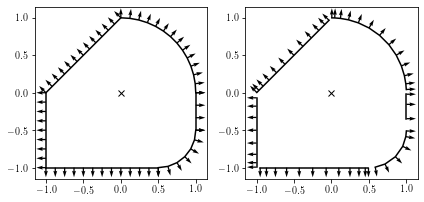

In [2]:
# line
def line_r(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    x = (x1-x0) * t + x0 
    y = (y1-y0) * t + y0
    return np.array([x, y])

def line_n(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    l = np.sqrt((x1 - x0)**2 + (y1 -y0)**2)
    nx = (y1 - y0)/l*np.ones(len(t))
    ny = (x0 - x1)/l*np.ones(len(t))
    return np.array([nx, ny])

def line_arc(t, x0 = 0, y0 = 0, x1 = 1, y1 = 1):
    l = np.sqrt((x1 - x0)**2 + (y1 -y0)**2)
    return np.array(t * l)

# circle arc
def circle_r(t, R = 1, x0 = 0, y0 = 0, angle = 2*np.pi, shift = 0):
    x = x0 + R * np.cos(t*angle + shift)
    y = y0 + R * np.sin(t*angle + shift)
    return np.array([x, y])

def circle_n(t, angle = 2*np.pi, shift = 0, **kwargs):
    nx = np.cos(t*angle + shift)
    ny = np.sin(t*angle + shift)
    return np.array([nx, ny])

def circle_arc(t, R = 1, angle = 2*np.pi, **kwargs):
    return  np.array(R * angle *t)

def make_weird_billiard_full(dist = None):
    params_1 = {"angle" : np.pi/2}
    arc_1 = cv.curve(circle_r, circle_n, circle_arc, **params_1, distribution_function=dist)
    params_2 = {"x0": 0, "x1": -1, "y0": 1, "y1": 0}
    line_2 = cv.curve(line_r, line_n, line_arc, **params_2, distribution_function=dist, virtual = False)
    params_3 = {"x0": -1, "x1": -1, "y0": 0, "y1": -1}
    line_3 = cv.curve(line_r, line_n, line_arc, **params_3, distribution_function=dist, virtual = False)
    params_4 = {"x0": -1, "x1": 0.5, "y0": -1, "y1": -1}
    line_4 = cv.curve(line_r, line_n, line_arc, **params_4, distribution_function=dist)
    params_5 = {"R" : 0.5, "x0": 0.5, "y0" : -0.5 , "angle" : np.pi/2, "shift" : 3*np.pi/2}
    arc_5 = cv.curve(circle_r, circle_n, circle_arc, **params_5, distribution_function=dist)
    params_6 = {"x0": 1, "x1": 1, "y0": -0.5, "y1": 0}
    line_6 = cv.curve(line_r, line_n, line_arc, **params_6, distribution_function=dist)

    curves = [line_4, arc_5, line_6, arc_1, line_2, line_3 ]
    area = np.pi/4 + 1/2 + 1.5 + np.pi *0.5**2 + 0.5**2
    
    return bil.billiard(curves, area)

def chebyshev_nodes(t_vals):
    N = len(t_vals)
    pts = np.arange(1,N,1)
    t = np.cos((2*pts-1)/(2*N)*np.pi)[::-1]
    return (t+1)/2

def plot_basis_function(basis,i,j,k):
    basis.basis_functions[i].plot_fun(j,k)
    
bil0 = make_weird_billiard_full()
bil1 = make_weird_billiard_full(dist = chebyshev_nodes)

fig = figure(figsize = (6,8))
subplot(1,2,1)
bil0.plot_boundary()
subplot(1,2,2)
bil1.plot_boundary()

In [3]:
#fb_basis3.set_basis_size([100])
fb_basis = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : 0, "nu" : 4/3, "phi0" :-np.pi/2}])
fb_basis.set_basis_size([10])
rpw_basis = rpw.make_RPW_basis()
rpw_basis.set_basis_size([5,5])

def test_fb_basis(k,dk, solver = "DM", density = 100,  Mi = 100):
    N = list(np.arange(100,1001,100))
    print(N)
    ten0 = []
    ten1 = []
    for n in N:
        fb_basis.set_basis_size([n])
        problem0 = spec.spectrum(bil0, fb_basis)
        problem1 = spec.spectrum(bil1, fb_basis)
        k0, t0 = problem0.compute_k(k,dk,solver = solver, point_density = density, Mi = Mi)
        ten0.append(t0)
        k1, t1 = problem1.compute_k(k,dk,solver = solver, point_density = density, Mi = Mi)
        ten1.append(t1)
    return N, ten0, ten1 

def test_rpw_basis(k,dk, solver = "DM", density = 100,  Mi = 100):
    N = list(np.arange(100,1001,100))
    ten0 = []
    ten1 = []
    for n in N:
        rpw_basis.set_basis_size([n/2,n/2])
        problem0 = spec.spectrum(bil0, rpw_basis)
        problem1 = spec.spectrum(bil1, rpw_basis)
        start_time = time.time()
        k0, t0 = problem0.compute_k(k,dk,solver = solver, point_density = density, Mi = Mi)
        ten0.append(t0)
        k1, t1 = problem1.compute_k(k,dk,solver = solver, point_density = density, Mi = Mi)
        ten1.append(t1)
    return N, ten0, ten1 

In [4]:
fb_basis = fb.make_FB_basis(par_list=[{"x0" : -1.0, "y0" : 0, "nu" : 4/3, "phi0" :-np.pi/2}])
rpw_basis = rpw.make_RPW_basis()

problem0 = spec.spectrum(bil0, fb_basis)
problem1 = spec.spectrum(bil1, fb_basis)
problem2 = spec.spectrum(bil0, rpw_basis)
problem3 = spec.spectrum(bil1, rpw_basis)

8.388869047164917 seconds
8.17688798904419 seconds
4.0103232860565186 seconds
3.9855968952178955 seconds


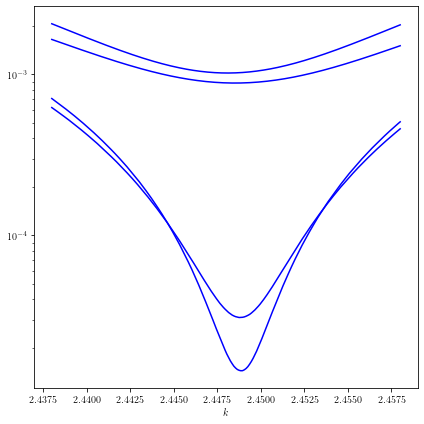

In [5]:
N = 150
M = 100
Mi = 100

solver = "PSM"
fb_basis.set_basis_size([N])
rpw_basis.set_basis_size([N//2,N//2])
eps = 1e-15

k0 = 2.448
dk = 0.01

fig = figure(figsize = (6,6))

start_time = time.time()
problem0.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))

start_time = time.time()
problem2.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))

tight_layout()


8.666471004486084 seconds
8.361863374710083 seconds
3.940126657485962 seconds
5.107468605041504 seconds


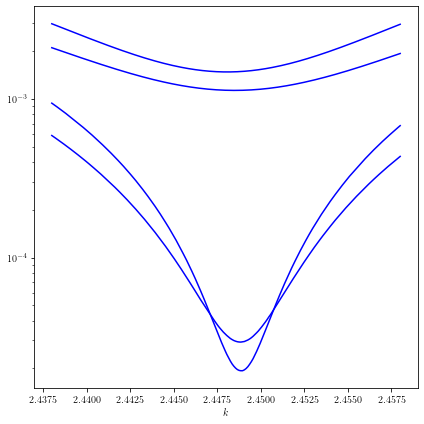

In [6]:
N = 150
M = 100
Mi = 100

solver = "PSM"
fb_basis.set_basis_size([N])
rpw_basis.set_basis_size([N//2,N//2])
eps = 1e-15

k0 = 2.448
dk = 0.01

fig = figure(figsize = (6,6))

start_time = time.time()
problem0.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))

start_time = time.time()
problem2.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))

tight_layout()


12.470176458358765 seconds
12.840664625167847 seconds
4.8869788646698 seconds
4.131458044052124 seconds


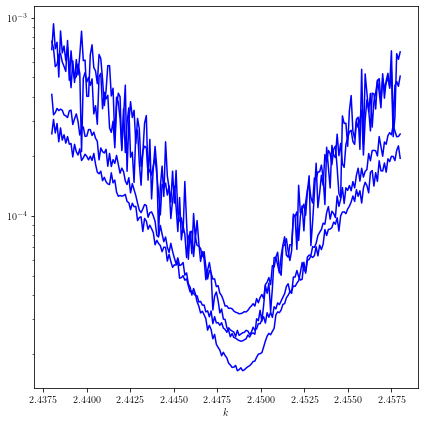

In [7]:
N = 150
M = 100
Mi = 100

solver = "PSM"
fb_basis.set_basis_size([N])
rpw_basis.set_basis_size([N//2,N//2])
eps = False

k0 = 2.448
dk = 0.01

fig = figure(figsize = (6,6))

start_time = time.time()
problem0.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))

start_time = time.time()
problem2.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))

tight_layout()


15.954049587249756 seconds
15.805378675460815 seconds
1.38150954246521 seconds
1.4286553859710693 seconds


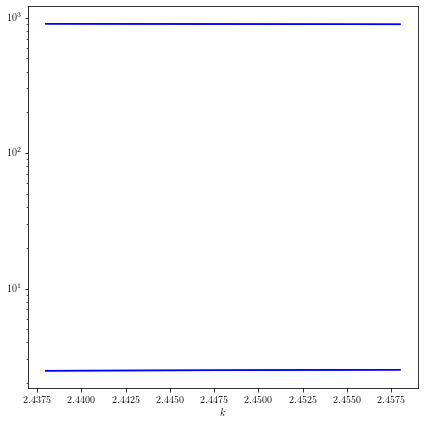

In [8]:
N = 150
M = 100
Mi = 100

solver = "DM"
fb_basis.set_basis_size([N])
rpw_basis.set_basis_size([N//2,N//2])
eps = False

k0 = 2.448
dk = 0.01

fig = figure(figsize = (6,6))

start_time = time.time()
problem0.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))

start_time = time.time()
problem2.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk, solver = solver, eps = eps)
print("%s seconds" % (time.time() - start_time))

tight_layout()

5.648441314697266 seconds
2.8802685737609863 seconds
2.6502060890197754 seconds
2.38771653175354 seconds


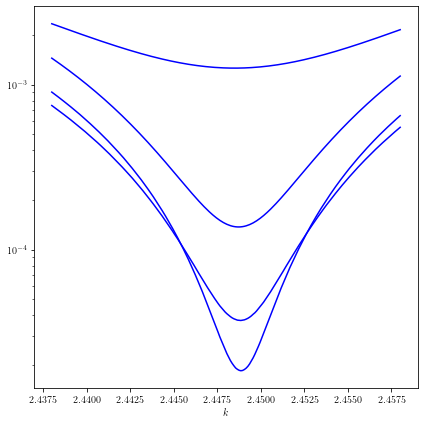

In [9]:
N = 50
M = 100
Mi = 100

solver = "PSM"
fb_basis.set_basis_size([N])
rpw_basis.set_basis_size([N//2,N//2])

k0 = 2.448
dk = 0.01

fig = figure(figsize = (6,6))

start_time = time.time()
problem0.plot_tension(k0 -dk, k0+dk, solver = solver, eps = False)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk, solver = solver)
print("%s seconds" % (time.time() - start_time))

start_time = time.time()
problem2.plot_tension(k0 -dk, k0+dk, solver = solver)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk, solver = solver)
print("%s seconds" % (time.time() - start_time))

tight_layout()


19.736142873764038 seconds
19.195836544036865 seconds
1.8132381439208984 seconds
1.7467517852783203 seconds


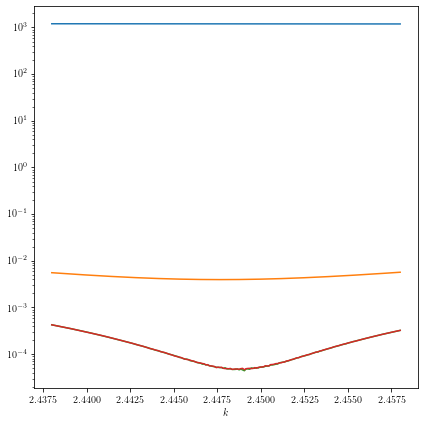

In [9]:
N = 200
M = 100
Mi = 100

solver = "DM"
fb_basis.set_basis_size([N])
rpw_basis.set_basis_size([N//2,N//2])

k0 = 2.448
dk = 0.01

fig = figure(figsize = (6,6))

start_time = time.time()
problem0.plot_tension(k0 -dk, k0+dk, solver = solver, eps = False)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem1.plot_tension(k0 -dk, k0+dk, solver = solver)
print("%s seconds" % (time.time() - start_time))

start_time = time.time()
problem2.plot_tension(k0 -dk, k0+dk, solver = solver)
print("%s seconds" % (time.time() - start_time))
start_time = time.time()
problem3.plot_tension(k0 -dk, k0+dk, solver = solver)
print("%s seconds" % (time.time() - start_time))

tight_layout()


138.40633511543274 seconds
9.148172855377197 seconds


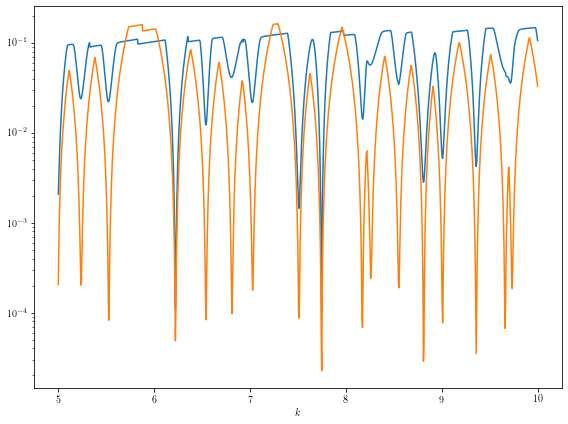

In [10]:
k1 = 5
k2 = 10

fig = figure(figsize = (8,6))
#subplot(1,2,1)
start_time = time.time()
problem1.plot_tension(k1, k2, grid = 1000)
print("%s seconds" % (time.time() - start_time))

#subplot(1,2,2)
start_time = time.time()
problem3.plot_tension(k1, k2, grid = 1000)
print("%s seconds" % (time.time() - start_time))

tight_layout()

74.97568941116333 seconds
27.40587854385376 seconds


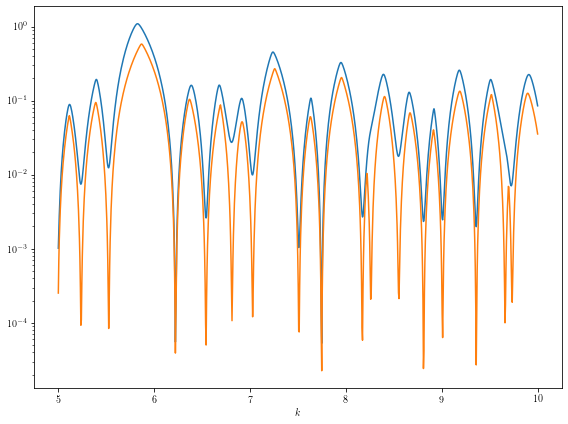

In [11]:
k1 = 5
k2 = 10

fig = figure(figsize = (8,6))
#subplot(1,2,1)
start_time = time.time()
problem1.plot_tension(k1, k2, grid = 1000, solver="PSM")
print("%s seconds" % (time.time() - start_time))

#subplot(1,2,2)
start_time = time.time()
problem3.plot_tension(k1, k2, grid = 1000, solver="PSM")
print("%s seconds" % (time.time() - start_time))

tight_layout()

85.37571406364441 seconds
30.692304611206055 seconds


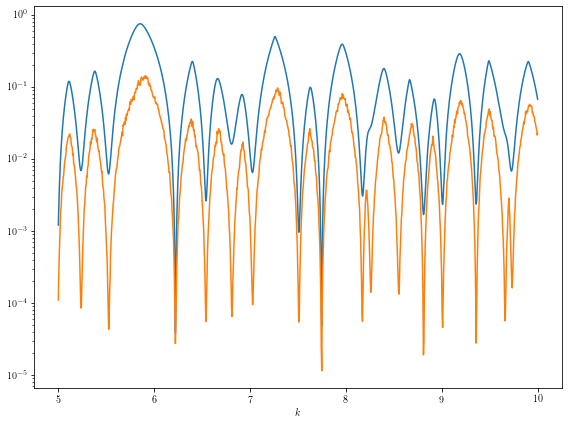

In [12]:
k1 = 5
k2 = 10
eps = 1e-20
fig = figure(figsize = (8,6))
#subplot(1,2,1)
start_time = time.time()
problem1.plot_tension(k1, k2, grid = 1000, solver="PSM", eps = eps)
print("%s seconds" % (time.time() - start_time))

#subplot(1,2,2)
start_time = time.time()
problem3.plot_tension(k1, k2, grid = 1000, solver="PSM", eps = eps)
print("%s seconds" % (time.time() - start_time))

tight_layout()

In [21]:
N = 200
M = 100
Mi = 100

solver = "SM"
fb_basis.set_basis_size([N])
rpw_basis.set_basis_size([N//2,N//2])

k0 = 8.5
dk = 0.1

k, ten =  problem2.compute_k(k0, dk, solver = solver, point_density = M, Mi= Mi, scale_basis = False)

In [22]:
k

8.552650023975138

In [23]:
ten

0.005544050049165096

In [3]:
N = 200
M = 100
overlap = 0.1

solver = "SM"
fb_basis.set_basis_size([N])
rpw_basis.set_basis_size([N//2,N//2])

k0 = 8.5
dk = 0.1
n = 20

k, ten = problem2.compute_spectrum(k0, dk, n, overlap = overlap, point_density = M, scale_basis = False, eps = 0.5e-15, return_tensions = True)

NameError: name 'fb_basis' is not defined